In [1]:
from src.process import *
from src.models import *
from src.utils import *
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import os 
import sys
from datasets import load_dataset, Dataset, load_from_disk
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
df = get_encoders()
display(HTML(df.to_html()))

,encoder,size,desc
0,all-MiniLM-L6-v2,384,"MiniLM is a compact distilled model with RoBERTa-Large as teacher, version with 6 layers (30M parameters). To obtain the sentence transformer, the model is fine-tuned on a set of 1B sentence pairs with the task: given a sentence from a pair, the model must predict which of a set of other randomly sampled sentences is matched with it."
1,all-mpnet-base-v2,768,"MPNet (110M parameters, same architecture as BERT-base) is a training method combining MLM (Bert) and PLM (XLNet). To obtain the sentence transformer, the model is fine-tuned on a set of 1B sentence pairs with the task: given a sentence from a pair, the model must predict which of a set of other randomly sampled sentences is matched with it."
2,gtr-t5-large,768,"T5-Base (220M parameters) is a text-to-text transformer pre-trained on Colossal Clean Crawled Corpus. To obtain the sentence transformer, the model is fine-tuned for semantic search: given a query/question, if can find relevant passages."
3,all-roberta-large-v1,1024,"The base model is Roberta (354M parameters). To obtain the sentence transformer, the model is fine-tuned on a set of 1B sentence pairs with the task: given a sentence from a pair, the model must predict which of a set of other randomly sampled sentences is matched with it."


In [206]:
## A toi de jouer

In [3]:
list_models = os.listdir('models/')
list_models.remove('.ipynb_checkpoints')
list_models.remove('model_parameters')
list_models = sorted(list_models, key = lambda x:x.split('_')[-1] + x.split('_')[0][1::])

res = []
for i, name in enumerate(tqdm(list_models)):
    model = torch.load('models/' + name,  map_location=torch.device(device))
    model = model.to(device)
    encoder = name.split('_')[-1]
    _, _, test = load_data_embedded(encoder, test_only=True)
    accuracy, acc_per_position, acc_per_len, acc_first, acc_last = get_model_stats(model, test)
    nb_parameters = get_nb_parameters(model)
    res.append([encoder, name.split('_')[0], '_'.join(name.split('_')[:-1]), nb_parameters, accuracy, acc_per_position, acc_per_len, acc_first, acc_last])
    
df_res = pd.DataFrame(res, columns=['encoder', 'model_type', 'model', 'nb_parameters', 'accuracy', 'acc_per_position', 'acc_per_len', 'acc_first', 'acc_last'])

100%|██████████| 28/28 [02:21<00:00,  5.07s/it]


In [7]:
df_res.head()

,encoder,model_type,model,nb_parameters,accuracy,acc_per_position,acc_per_len,acc_first,acc_last,context,Model type
0,all-MiniLM-L6-v2,MLP,MLP_,25748,0.752842,"[0.851, 0.736, 0.7839248434237995, 0.721132897...","[0.7142857142857143, 0.7333333333333333, 0.781...",0.851,0.652,None,MLP
1,all-MiniLM-L6-v2,RNN,RNN_50_4,37304,0.759432,"[0.833, 0.76, 0.767223382045929, 0.74618736383...","[0.7380952380952381, 0.775, 0.7909604519774012...",0.833,0.725,Past,RNN
2,all-MiniLM-L6-v2,GRU,GRU_100_2,206804,0.766667,"[0.835, 0.77, 0.7807933194154488, 0.7668845315...","[0.7380952380952381, 0.75, 0.7923728813559322,...",0.835,0.725,Past,GRU
3,all-MiniLM-L6-v2,LSTM,LSTM_100_2,275604,0.777649,"[0.849, 0.781, 0.7766179540709812, 0.766884531...","[0.7738095238095238, 0.7666666666666667, 0.810...",0.849,0.748,Past,LSTM
4,all-MiniLM-L6-v2,biGRU,biGRU_100_2,473604,0.784367,"[0.84, 0.796, 0.7985386221294363, 0.7690631808...","[0.7976190476190477, 0.8, 0.8305084745762712, ...",0.840,0.748,Full,GRU


In [5]:
dic_context={'MLP': 'None',
             'RNN': 'Past',
             'GRU': 'Past',
             'LSTM': 'Past',
             'biRNN': 'Full',
             'biLSTM': 'Full',
             'biGRU': 'Full',
}

dic_model={'MLP': 'MLP',
             'RNN': 'RNN',
             'GRU': 'GRU',
             'LSTM': 'LSTM',
             'biRNN': 'RNN',
             'biLSTM': 'LSTM',
             'biGRU': 'GRU',
}

df_res['context'] = df_res['model_type'].replace(dic_context)
df_res['Model type'] = df_res['model_type'].replace(dic_model)

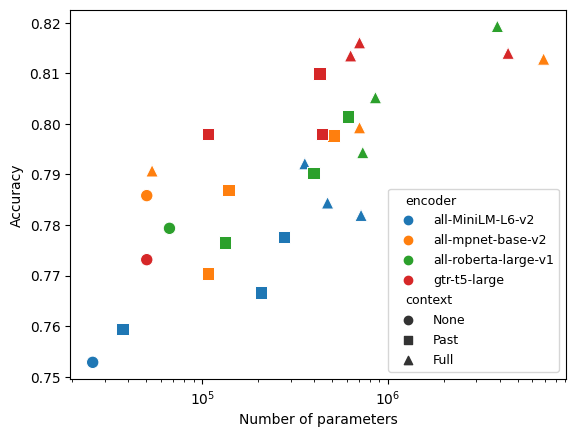

In [6]:
labels = df_res['encoder']
gfg = sns.scatterplot(x=df_res['nb_parameters'], y=df_res['accuracy'], hue=labels, style=df_res['context'], markers=['o', 's', '^'], s=80)
plt.xscale('log')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.setp(gfg.get_legend().get_texts(), fontsize='9') 
#plt.savefig('images/acc_par.png', bbox_inches='tight')
plt.show()

## Analysis for some fixed numbers of parameters

In [8]:
list_models = os.listdir('models/model_parameters/')
list_models.remove('.ipynb_checkpoints')
list_models = sorted(list_models, key = lambda x:x.split('_')[-1] + x.split('_')[0][1::])

res = []
for i, name in enumerate(tqdm(list_models)):
    model = torch.load('models/model_parameters/' + name,  map_location=torch.device(device))
    model = model.to(device)
    encoder = 'gtr-t5-large'
    _, _, test = load_data_embedded(encoder, test_only=True)
    accuracy, acc_per_position, acc_per_len, acc_first, acc_last = get_model_stats(model, test)
    nb_parameters = get_nb_parameters(model)
    res.append([encoder, name.split('_')[0], name.split('_')[-1], nb_parameters, accuracy, acc_per_position, acc_per_len, acc_first, acc_last])
    
df_res_param = pd.DataFrame(res, columns=['encoder', 'model_type', 'num', 'nb_parameters', 'accuracy', 'acc_per_position', 'acc_per_len', 'acc_first', 'acc_last'])

100%|██████████| 30/30 [02:31<00:00,  5.05s/it]


In [9]:
df_res_param['context'] = df_res_param['model_type'].replace(dic_context)
df_res_param['Model type'] = df_res_param['model_type'].replace(dic_model)

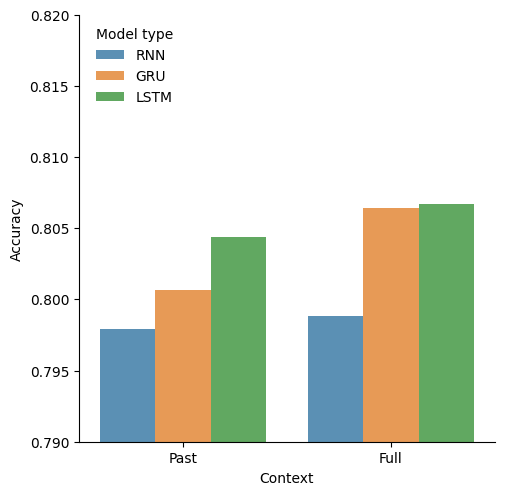

In [10]:
df_res_param = df_res_param.sort_values('accuracy')
g = sns.catplot(data=df_res_param[df_res_param['num']=='1'], x="context", y="accuracy", hue="Model type", kind="bar", alpha=0.8)
g.set(ylim=(0.79, 0.82))
plt.xlabel("Context")
plt.ylabel("Accuracy")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.14, 0., 0, 0.97))
plt.savefig('images/acc_100.png', bbox_inches='tight')

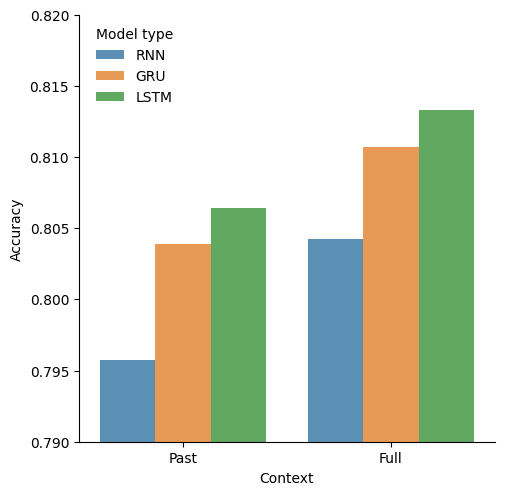

In [11]:
df_res_param = df_res_param.sort_values('accuracy')
g = sns.catplot(data=df_res_param[df_res_param['num']=='2'], x="context", y="accuracy", hue="Model type", kind="bar", alpha=0.8)
g.set(ylim=(0.79, 0.82))
plt.xlabel("Context")
plt.ylabel("Accuracy")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.14, 0., 0, 0.97))
plt.savefig('images/acc_200.png', bbox_inches='tight')

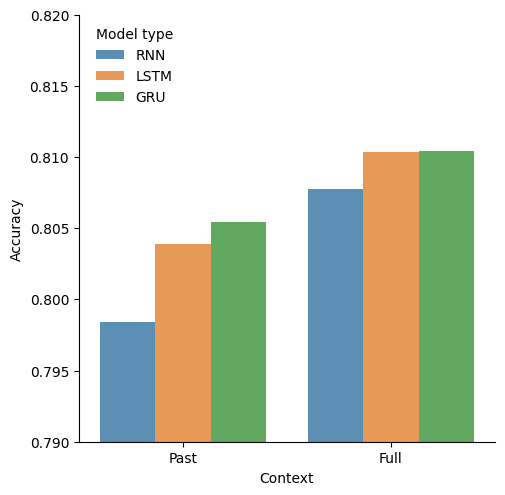

In [12]:
df_res_param = df_res_param.sort_values('accuracy')
g = sns.catplot(data=df_res_param[df_res_param['num']=='3'], x="context", y="accuracy", hue="Model type", kind="bar", alpha=0.8)
g.set(ylim=(0.79, 0.82))
plt.xlabel("Context")
plt.ylabel("Accuracy")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.14, 0., 0, 0.97))
plt.savefig('images/acc_300.png', bbox_inches='tight')

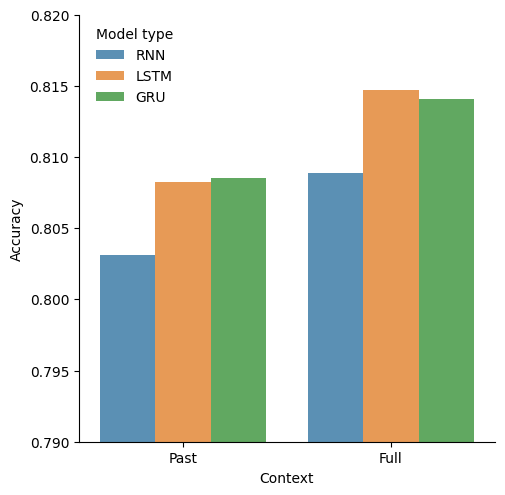

In [13]:
df_res_param = df_res_param.sort_values('accuracy')
g = sns.catplot(data=df_res_param[df_res_param['num']=='4'], x="context", y="accuracy", hue="Model type", kind="bar", alpha=0.8)
g.set(ylim=(0.79, 0.82))
plt.xlabel("Context")
plt.ylabel("Accuracy")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.14, 0., 0, 0.97))
plt.savefig('images/acc_400.png', bbox_inches='tight')

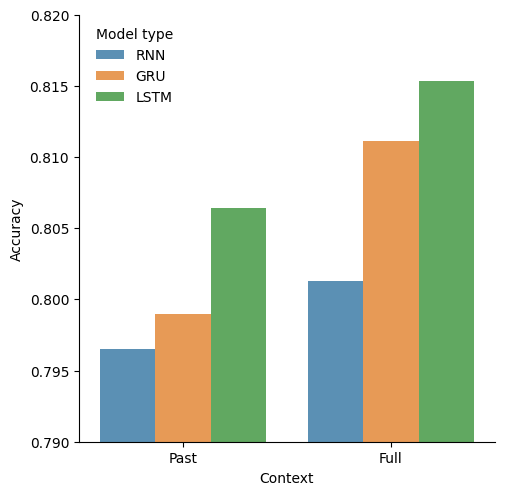

In [14]:
df_res_param = df_res_param.sort_values('accuracy')
g = sns.catplot(data=df_res_param[df_res_param['num']=='5'], x="context", y="accuracy", hue="Model type", kind="bar", alpha=0.8)
g.set(ylim=(0.79, 0.82))
plt.xlabel("Context")
plt.ylabel("Accuracy")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.14, 0., 0, 0.97))
plt.savefig('images/acc_500.png', bbox_inches='tight')

## Average accuracy for first and last utterances

In [17]:
df_res[df_res['model_type']=='MLP'][['accuracy', 'acc_first', 'acc_last']].mean()

accuracy     0.772771
acc_first    0.860750
acc_last     0.685250
dtype: float64

In [18]:
df_res[df_res['model_type']=='RNN'][['accuracy', 'acc_first', 'acc_last']].mean() - df_res[df_res['model_type']=='MLP'][['accuracy', 'acc_first', 'acc_last']].mean()


accuracy     0.003295
acc_first   -0.017750
acc_last     0.047500
dtype: float64

In [20]:
df_res[df_res['model_type']=='GRU'][['accuracy', 'acc_first', 'acc_last']].mean() - df_res[df_res['model_type']=='MLP'][['accuracy', 'acc_first', 'acc_last']].mean()

accuracy     0.012694
acc_first   -0.011750
acc_last     0.058000
dtype: float64

In [21]:
df_res[df_res['model_type']=='LSTM'][['accuracy', 'acc_first', 'acc_last']].mean() - df_res[df_res['model_type']=='MLP'][['accuracy', 'acc_first', 'acc_last']].mean()

accuracy     0.023902
acc_first   -0.002000
acc_last     0.069750
dtype: float64